### Libraries

In [4]:
import math, warnings
import inspect
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from sklearn.preprocessing import StandardScaler


# pytorch
import torch
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


### Parameters

In [5]:
##
## Parameters
##

# time step
dt=0.025
# units of time to warm up NVAR. need to have warmup_pts >= 1
warmup = 5.
# units of time to train for
traintime = 10.
# units of time to test for
testtime=20.
# total time to run for
maxtime = warmup+traintime+testtime
# how much of testtime to plot
plottime=20.
# Lyapunov time of the Lorenz system
lyaptime=1.104

# discrete-time versions of the times defined above
warmup_pts=round(warmup/dt)
traintime_pts=round(traintime/dt)
warmtrain_pts=warmup_pts+traintime_pts
testtime_pts=round(testtime/dt)
maxtime_pts=round(maxtime/dt)
plottime_pts=round(plottime/dt)
lyaptime_pts=round(lyaptime/dt)

# input dimension
d = 3
# number of time delay taps
k = 2
# size of linear part of feature vector
dlin = k*d
# size of nonlinear part of feature vector
dnonlin = int(dlin*(dlin+1)/2)
# total size of feature vector: constant + linear + nonlinear
dtot = 1 + dlin + dnonlin

# ridge parameter for regression
ridge_param = 2.5e-6

# t values for whole evaluation time
# (need maxtime_pts + 1 to ensure a step of dt)
t_eval=np.linspace(0,maxtime,maxtime_pts+1)

### Lorenz 63'


In [6]:
##
## Lorenz '63
##

sigma = 10
beta = 8 / 3
rho = 28

def lorenz(t, y):

  dy0 = sigma * (y[1] - y[0])
  dy1 = y[0] * (rho - y[2]) - y[1]
  dy2 = y[0] * y[1] - beta * y[2]

  # since lorenz is 3-dimensional, dy/dt should be an array of 3 values
  return [dy0, dy1, dy2]


### Solution of Lorenz 63

In [7]:
# I integrated out to t=50 to find points on the attractor, then use these as the initial conditions

lorenz_soln = solve_ivp(lorenz, (0, maxtime), [17.67715816276679, 12.931379185960404, 43.91404334248268] , t_eval=t_eval, method='RK23')

# total variance of Lorenz solution
total_var=np.var(lorenz_soln.y[0:d,:])

### Vizualize and Split the Sequence and normalize for training

[[17.67715816 15.77695495 12.83202575  9.49915688  6.31667148]
 [12.93137919  5.68211629 -0.14898817 -3.81814923 -5.64699747]
 [43.91404334 44.85194679 42.87695699 39.54693535 36.08397169]]


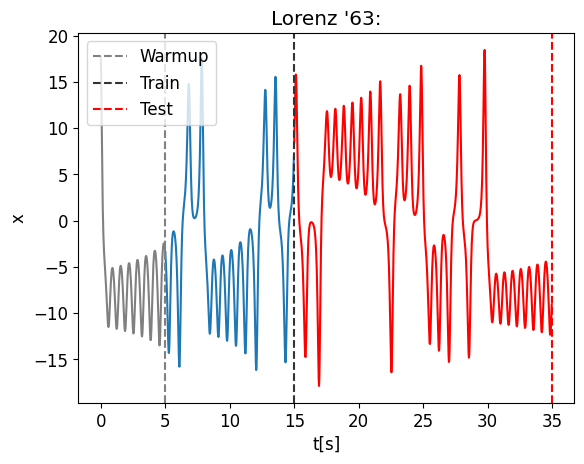

In [37]:
# create an array to hold the linear part of the feature vector
x = np.zeros((d,maxtime_pts))

# fill in the linear part of the feature vector for all times
for i in range(maxtime_pts):
  x[:,i]=lorenz_soln.y[:,i]

lor_train = x[:,warmup_pts:warmtrain_pts]
lor_test = x[:,warmtrain_pts:maxtime_pts]

scaler = StandardScaler()

lor_train = scaler.fit_transform(lor_train.T).T

lor_test = scaler.transform(lor_test.T).T

print(x[:,0:5])
plt.plot(t_eval[0:warmup_pts+1],x[0,0:warmup_pts+1],"0.5")
plt.plot(t_eval[warmup_pts:warmtrain_pts],x[0,warmup_pts:warmtrain_pts])
plt.plot(t_eval[warmtrain_pts:maxtime_pts],x[0,warmtrain_pts:maxtime_pts], "r")
plt.axvline(x=warmup, ls='--', color='0.5', label='Warmup')
plt.axvline(x=warmtrain_pts*dt, ls='--', color='0.2', label='Train')
plt.axvline(x=maxtime, ls='--', color='r', label='Test')
plt.legend(loc='upper left')

plt.title("Lorenz '63:")
plt.xlabel("t[s]")
plt.ylabel("x")
plt.show()


### Define Transformer

In [38]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):

    def __init__(self, input_dim=3, d_model=64, nhead=4, nlayers=2, dropout=0.2, norm_first=True, batch_first=True):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.decoder = nn.Linear(d_model, input_dim)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        out = self.decoder(x[:,-1,:])
        return out

### Create batches

In [39]:
def toSequence(seq_size, obs):
  x = []
  y = []
  for i in range(len(obs[0,:]) - seq_size):
    window = obs[:,i:(i + seq_size)]
    last = obs[:,i + seq_size]
    x.append(window)
    y.append(last)

  return torch.tensor(x, dtype=torch.float32).transpose(2,1), torch.tensor(y, dtype=torch.float32)

SEQUENCE_SIZE = 2
batch_size = 1

x_train, y_train = toSequence(SEQUENCE_SIZE, lor_train)
x_test, y_test = toSequence(SEQUENCE_SIZE, lor_test)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training the model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


At epoch: 0, loss: 0.06380726602583309
At epoch: 10, loss: 0.012756867134603453
At epoch: 20, loss: 0.006029805139405653
Epochs: 23, Sequence Length: 2


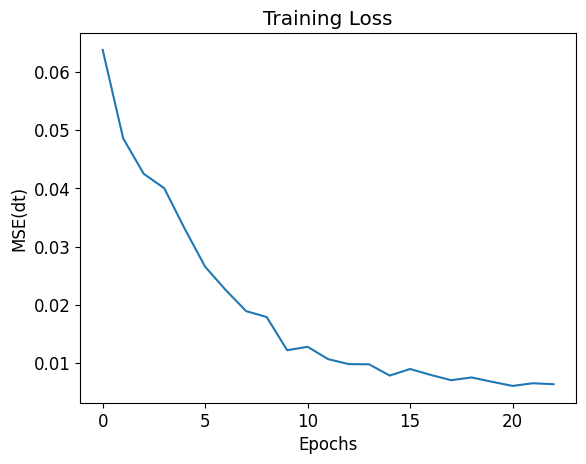

In [135]:
learning_rate = 0.0005

model = TransformerModel(d_model=32, nhead=4, nlayers=2).to(device)

criterion  = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)


epochs = 23
early_stop_count = 0
min_val_loss = float('inf')
loss_hist = []
current_loss = 0

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_batch = y_batch - x_batch[-1,-1,:]

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

    if (epoch % 10 == 0):
        print(f"At epoch: {epoch}, loss: {current_loss/traintime_pts}")
    loss_hist.append(current_loss/traintime_pts)
    scheduler.step()
    current_loss = 0

print("Epochs: {}, Sequence Length: {}".format(epochs, SEQUENCE_SIZE))
plt.plot(loss_hist)

# Add title and axis names
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE(dt)')
plt.show()


### Testing

In [136]:
# Evaluation
model.eval()
i = 0
predictions = np.zeros((testtime_pts,3))
predictions[0:SEQUENCE_SIZE+1,:] = lor_test[:,0:SEQUENCE_SIZE+1].T
with torch.no_grad():
    #for batch in test_loader:
    for i in range(testtime_pts-2*SEQUENCE_SIZE-1):
        #x_batch, y_batch = batch
        x_batch = torch.tensor(predictions[i:i+SEQUENCE_SIZE,:], dtype=torch.float32).reshape(1,SEQUENCE_SIZE,3)
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions[i+SEQUENCE_SIZE+1,:] = outputs.cpu() + predictions[i+SEQUENCE_SIZE,:]

pred_norm = np.copy(predictions)
pred_norm = pred_norm.T

predictions = scaler.inverse_transform(predictions)

lorPLT = scaler.inverse_transform(lor_test.T).T
lorPLT = lorPLT[:,0:len(predictions[0,:])]


# calculate NRMSE between true Lorenz and prediction for one Lyapunov time
test_mse = np.mean(np.abs(pred_norm[:,0:lyaptime_pts-1]-lor_test[:,0:lyaptime_pts-1]))
#test_nrmse = np.sqrt(np.mean((x[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1]-x_test[0:d,0:lyaptime_pts])**2)/total_var)
#print('test nrmse: '+ str(test_nrmse))
print("test MSE: {}".format(test_mse))
print("NRMSE loss: {}".format(np.sqrt(test_mse/total_var)))

test MSE: 0.7102770462855723
NRMSE loss: 0.05696711357911668


### Plot

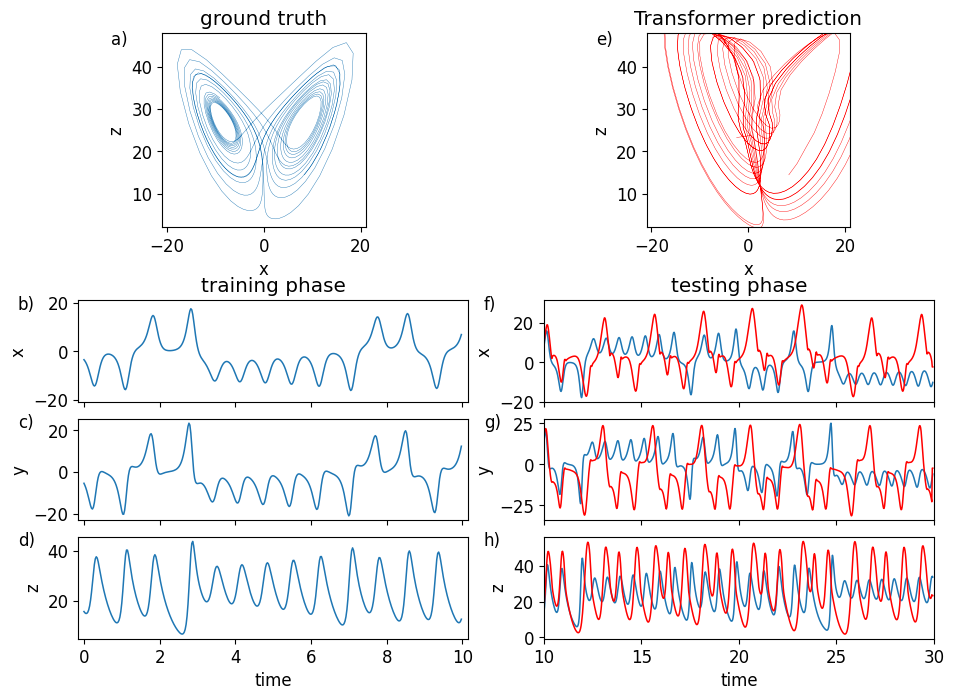

In [137]:

##
## Plot
##
predictions = predictions.T

t_linewidth=1.1
a_linewidth=0.3
plt.rcParams.update({'font.size': 12})

fig1 = plt.figure()
fig1.set_figheight(8)
fig1.set_figwidth(12)

xlabel=[10,15,20,25,30]
h=120
w=100

# top left of grid is 0,0
axs1 = plt.subplot2grid(shape=(h,w), loc=(0, 9), colspan=22, rowspan=38)
axs2 = plt.subplot2grid(shape=(h,w), loc=(52, 0), colspan=42, rowspan=20)
axs3 = plt.subplot2grid(shape=(h,w), loc=(75, 0), colspan=42, rowspan=20)
axs4 = plt.subplot2grid(shape=(h,w), loc=(98, 0), colspan=42, rowspan=20)
axs5 = plt.subplot2grid(shape=(h,w), loc=(0, 61), colspan=22, rowspan=38)
axs6 = plt.subplot2grid(shape=(h,w), loc=(52, 50),colspan=42, rowspan=20)
axs7 = plt.subplot2grid(shape=(h,w), loc=(75, 50), colspan=42, rowspan=20)
axs8 = plt.subplot2grid(shape=(h,w), loc=(98, 50), colspan=42, rowspan=20)

# true Lorenz attractor
axs1.plot(x[0,warmtrain_pts:maxtime_pts],x[2,warmtrain_pts:maxtime_pts],linewidth=a_linewidth)
axs1.set_xlabel('x')
axs1.set_ylabel('z')
axs1.set_title('ground truth')
axs1.text(-.25,.92,'a)', ha='left', va='bottom',transform=axs1.transAxes)
axs1.axes.set_xbound(-21,21)
axs1.axes.set_ybound(2,48)

# training phase x
axs2.set_title('training phase')
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[0,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
#axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[0,:],linewidth=t_linewidth, color='r')
axs2.set_ylabel('x')
axs2.text(-.155,0.87,'b)', ha='left', va='bottom',transform=axs2.transAxes)
axs2.axes.xaxis.set_ticklabels([])
axs2.axes.set_ybound(-21.,21.)
axs2.axes.set_xbound(-.15,10.15)

# training phase y
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[1,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
#axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[1,:],linewidth=t_linewidth,color='r')
axs3.set_ylabel('y')
axs3.text(-.155,0.87,'c)', ha='left', va='bottom',transform=axs3.transAxes)
axs3.axes.xaxis.set_ticklabels([])
axs3.axes.set_xbound(-.15,10.15)

# training phase z
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[2,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
#axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[2,:],linewidth=t_linewidth,color='r')
axs4.set_ylabel('z')
axs4.text(-.155,0.87,'d)', ha='left', va='bottom',transform=axs4.transAxes)
axs4.set_xlabel('time')
axs4.axes.set_xbound(-.15,10.15)

# prediction attractor
axs5.plot(predictions[0,:],predictions[2,:],linewidth=a_linewidth,color='r')
axs5.set_xlabel('x')
axs5.set_ylabel('z')
axs5.set_title('Transformer prediction')
axs5.text(-.25,0.92,'e)', ha='left', va='bottom',transform=axs5.transAxes)
axs5.axes.set_xbound(-21,21)
axs5.axes.set_ybound(2,48)

# testing phase x
axs6.set_title('testing phase')
axs6.set_xticks(xlabel)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[0,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,predictions[0,0:plottime_pts],linewidth=t_linewidth,color='r')
axs6.set_ylabel('x')
axs6.text(-.155,0.87,'f)', ha='left', va='bottom',transform=axs6.transAxes)
axs6.axes.xaxis.set_ticklabels([])
axs6.axes.set_xbound(traintime,traintime+plottime)

# testing phase y
axs7.set_xticks(xlabel)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[1,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,predictions[1,0:plottime_pts],linewidth=t_linewidth,color='r')
axs7.set_ylabel('y')
axs7.text(-.155,0.87,'g)', ha='left', va='bottom',transform=axs7.transAxes)
axs7.axes.xaxis.set_ticklabels([])
axs7.axes.set_xbound(traintime,traintime+plottime)

# testing phase z
axs8.set_xticks(xlabel)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[2,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,predictions[2,0:plottime_pts],linewidth=t_linewidth,color='r')
axs8.set_ylabel('z')
axs8.text(-.155,0.87,'h)', ha='left', va='bottom',transform=axs8.transAxes)
axs8.set_xlabel('time')
axs8.axes.set_xbound(traintime,traintime+plottime)